Import dependencies

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


# **Dataset Loading and Analysis**

In [ ]:
# Data Collection
import pandas_datareader as pdr
key=""

In [ ]:
# df = pdr.get_data_tiingo('AAPL', api_key=key)

In [ ]:
dataset=pd.read_csv('/content/APEXFOOT_data.csv')

In [ ]:
dataset.shape

(2650, 6)

In [ ]:
dataset.head()

,Date,Open,High,Low,Close,Volume
0,10/1/2012,180.165289,184.100748,175.521448,181.503345,22000
1,10/2/2012,184.179457,186.462023,179.535616,185.202676,54400
2,10/3/2012,186.540732,199.842582,186.540732,196.615506,101200
3,10/4/2012,193.624557,197.953562,189.138135,193.860685,13200
4,10/7/2012,192.837466,192.837466,182.054309,183.943329,10000


In [ ]:
dataset.tail()

,Date,Open,High,Low,Close,Volume
2645,2/14/2024,256.3,259.6,255.0,257.2,29754
2646,2/15/2024,257.2,260.0,254.4,255.3,22813
2647,2/18/2024,255.0,258.0,245.1,249.3,24703
2648,2/19/2024,255.0,257.7,250.2,255.3,19892
2649,2/20/2024,251.0,257.8,251.0,253.3,18864


In [ ]:
#Statistical measure of dataset
dataset.describe()

,Open,High,Low,Close,Volume
count,2650.000000,2650.000000,2650.000000,2650.000000,2.650000e+03
mean,249.676203,253.078529,245.504566,248.377089,4.596915e+04
std,52.951528,53.996014,51.389107,52.439549,8.855168e+04
min,165.289256,167.650531,161.353798,164.817001,0.000000e+00
25%,213.242818,216.450217,210.940575,212.652499,6.259000e+03
50%,253.443526,256.316411,250.295159,252.262889,1.680000e+04
75%,272.550177,277.000000,268.181818,271.704053,4.732150e+04
max,473.829201,476.190476,449.429358,466.824085,1.036185e+06


In [ ]:
# number of missing values in each column
dataset.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0


/tmp/ipython-input-2539782210.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset['Close'])


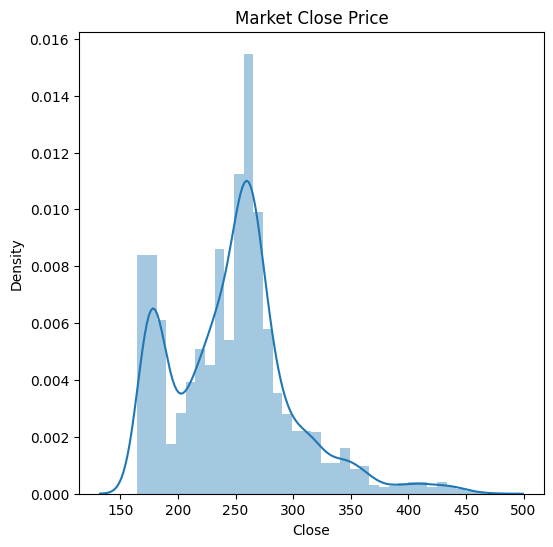

In [ ]:
# Close feature distribution
plt.figure(figsize=(6,6))
sns.distplot(dataset['Close'])
plt.title('Market Close Price')
plt.show()

# **DATASET PREPROCESSING**

We need only "Close" feature for predict stock market price.

No need other features, so extract "Close" from dataset


In [ ]:
ds_close=dataset.reset_index()['Close']

In [ ]:
print(ds_close)

0       181.503345
1       185.202676
2       196.615506
3       193.860685
4       183.943329
           ...    
2645    257.200000
2646    255.300000
2647    249.300000
2648    255.300000
2649    253.300000
Name: Close, Length: 2650, dtype: float64


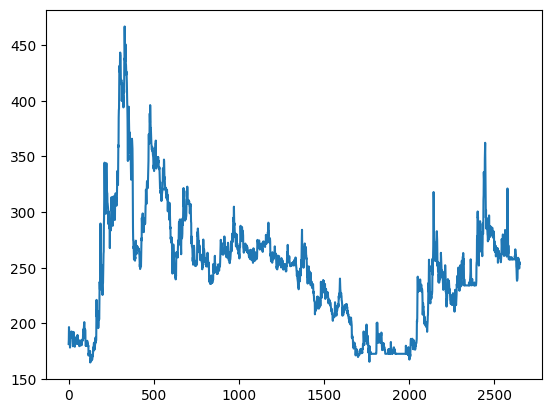

In [ ]:
# Ploat "close" feature value from dataset
import matplotlib.pyplot as plt
plt.plot(ds_close)

In [ ]:
# Scaled dataset, value between 0-1
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
ds_close=scaler.fit_transform(np.array(ds_close).reshape(-1,1))

In [ ]:
print(ds_close)

[[0.0552515 ]
 [0.06750065]
 [0.10529059]
 ...
 [0.27973847]
 [0.29960555]
 [0.29298319]]


This is a time series dataset. its means stock price depend on prevous date stock price

So there are not possible to split dataset by use Cross Validation or randomseed

split dataset manually

In [ ]:
##splitting dataset into train and test split
train_size=int(len(ds_close)*0.80)
test_size=len(ds_close)-train_size
train_data,test_data=ds_close[0:train_size,:],ds_close[train_size:len(ds_close),:1]

In [ ]:
train_size,test_size

(2120, 530)

In [ ]:
train_data

array([[0.0552515 ],
       [0.06750065],
       [0.10529059],
       ...,
       [0.30586396],
       [0.27001564],
       [0.27603597]])

create dataset by use "close" feature.

Here features will be previous days data, and target will be predict next days stock close price based on previous days close price.

f1--f2--f3--f4------Y

140-130-166 187-----156

130-166-187-156-----149

In [ ]:
import numpy as np
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   # i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape), print(Y_train.shape)

(2019, 100)
(2019,)


(None, None)

In [ ]:
print(X_test.shape), print(Y_test.shape)

(429, 100)
(429,)


(None, None)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# **LSTM Model**

In [ ]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
# model=Sequential()
# model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
# model.add(LSTM(50,return_sequences=True))
# model.add(LSTM(50))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error',optimizer='adam')


LSTM Model arcitecture summary

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization

model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(100,1)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (None, 100, 256)       │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 100, 128)       │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 342,913 (1.31 MB)

 Trainable params: 342,913 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

# **Training LSTM Model**

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [ ]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=100,
    batch_size=64,
    verbose=1
)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0344 - mae: 0.1298 - val_loss: 0.0025 - val_mae: 0.0376
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0022 - mae: 0.0311 - val_loss: 0.0017 - val_mae: 0.0268
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0017 - mae: 0.0269 - val_loss: 0.0017 - val_mae: 0.0285
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0014 - mae: 0.0248 - val_loss: 0.0016 - val_mae: 0.0263
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0013 - mae: 0.0237 - val_loss: 0.0023 - val_mae: 0.0372
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0015 - mae: 0.0264 - val_loss: 0.0013 - val_mae: 0.0231
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0011 - mae: 0.0219 - val_loss: 0.0012 - val_mae: 0.0225
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 9.4428e-04 - mae: 0.0202 - val_loss: 0.0012 - val_mae: 0.0228
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step 

In [ ]:
import tensorflow as tf

In [ ]:
# Lets Do the prediction and check performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


# **LSTM MODEL TRAINING AND VALIDATION ANALYSIS**

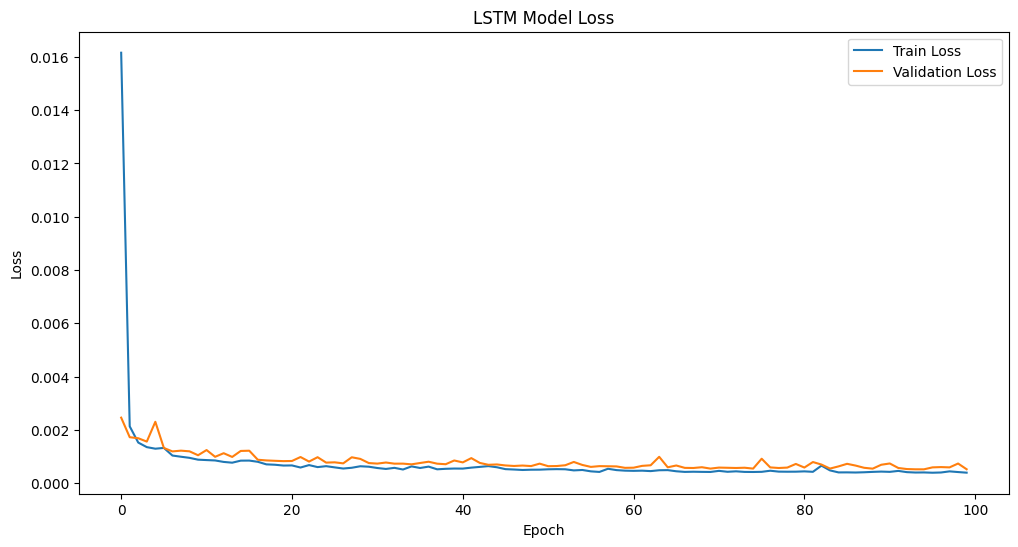

In [ ]:
# Plot training and validation loss and accuracy
import matplotlib.pyplot as plt

if 'history' in locals() and history is not None:
    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



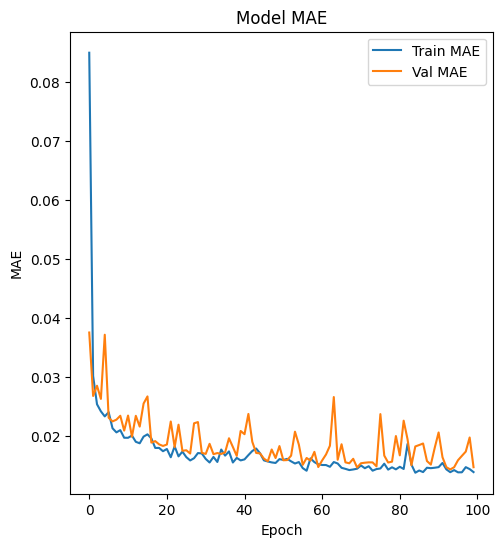

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))


# MAE
plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()


In [ ]:
# Transformback to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# **RMSE and MAPE table for LSTM Model**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import math # Import the math module

# Calculate MAPE for LSTM
train_mape = mean_absolute_percentage_error(scaler.inverse_transform(Y_train.reshape(-1, 1)), train_predict)
test_mape = mean_absolute_percentage_error(scaler.inverse_transform(Y_test.reshape(-1, 1)), test_predict)

# Get RMSE values (assuming they were calculated previously and stored in variables)
train_rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(Y_train.reshape(-1, 1)), train_predict))
test_rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(Y_test.reshape(-1, 1)), test_predict))


# Create a performance comparison table
performance_data = {'Metric': ['RMSE', 'MAPE'],
                    'Train': [train_rmse, train_mape],
                    'Test': [test_rmse, test_mape]}

performance_df = pd.DataFrame(performance_data)

print("LSTM Model Performance Comparison:")
display(performance_df)

LSTM Model Performance Comparison:


,Metric,Train,Test
0,RMSE,5.478190,6.924076
1,MAPE,0.014353,0.016766


plot how model train and test the dataset

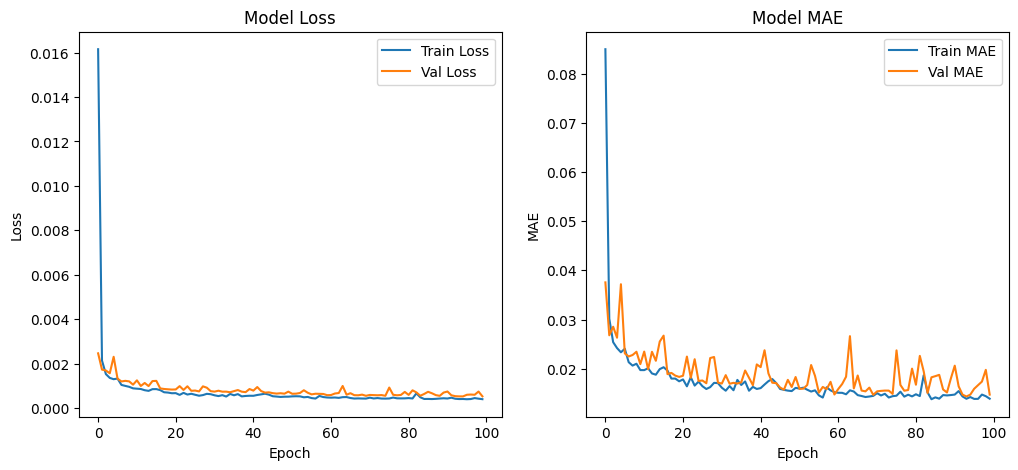

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

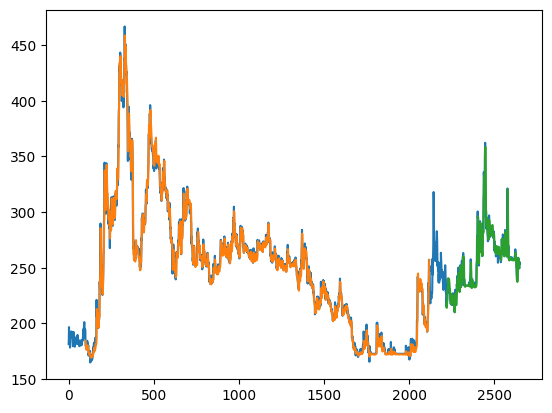

In [ ]:

# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(ds_close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(ds_close)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(ds_close)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(ds_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# **FUTURE PREDICTION**

In [ ]:
len(test_data)

530

We predict 30 days stock price based on last 100 days of test data

In [ ]:
x_input=test_data[430:].reshape(1,-1)
x_input.shape


(1, 100)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

Based on last 100 days stock price, we predict next 30 days stock price

In [ ]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[0.28921545]
101
1 day input [0.3810907  0.34978499 0.32931587 0.32841282 0.33985145 0.3371423
 0.32901486 0.3169742  0.31998436 0.32449961 0.35038702 0.33112197
 0.33262705 0.39433542 0.39165637 0.37543159 0.36251798 0.36947146
 0.37708718 0.35821345 0.32079711 0.3280817  0.32543276 0.3151681
 0.32642611 0.40258327 0.48536278 0.51781235 0.51085887 0.41847694
 0.38966966 0.32377717 0.34827991 0.33371071 0.3078835  0.30722127
 0.30689015 0.30689015 0.30854574 0.30722127 0.30689015 0.30689015
 0.31351251 0.30689015 0.30689015 0.30887686 0.30854574 0.31020133
 0.30953909 0.30689015 0.30920797 0.31351251 0.30821462 0.30689015
 0.30689015 0.30689015 0.30689015 0.30920797 0.3078835  0.30689015
 0.30689015 0.30689015 0.30689015 0.30689015 0.30689015 0.30689015
 0.30689015 0.30689015 0.30689015 0.30689015 0.31748593 0.31417475
 0.30755238 0.33669077 0.32642611 0.32079711 0.31285027 0.3188104
 0.30920797 0.28536747 0.28106294 0.26119586 0.24927561 0.24331548
 0.2436466  0.24861337 0.2509312  0.

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
len(ds_close)

2650

Plot predicted 30 days stock close price based on previous 100 days stock close price

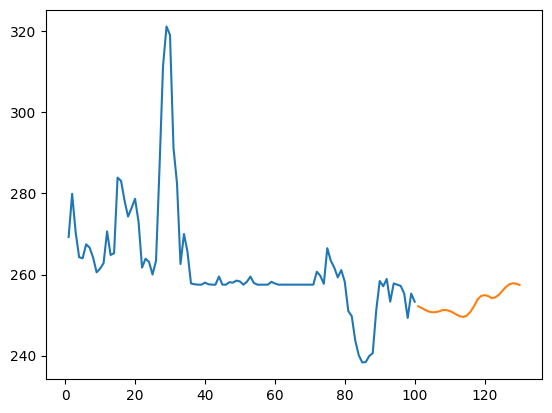

In [ ]:
plt.plot(day_new,scaler.inverse_transform(ds_close[2550:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

Plot 30 days stock close price adjust with last 365 days stock close price

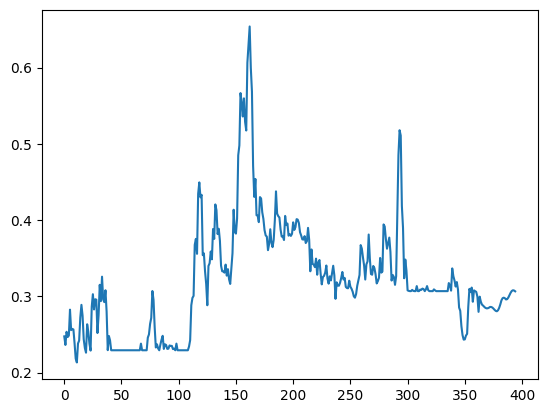

In [ ]:
df3=ds_close.tolist()
df3.extend(lst_output)
plt.plot(df3[2285:])

Plot predicted 30 days stock close price adjust with full dataset close price

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

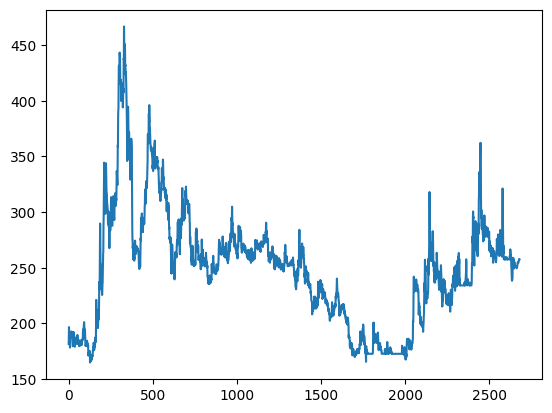

In [ ]:
plt.plot(df3)

# **Implement a traditional statistical model**

# **ARIMA MODEL**

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df=pd.read_csv('/content/APEXFOOT_data.csv')

In [ ]:
df = df.drop(columns=['Open','High','Low','Volume'], axis=1)

In [ ]:
# Convert Month into Datetime
df['Date']=pd.to_datetime(df['Date'])

# **DATA PREPROCESSING**

Hence ARIMA Model work for time sequence, so here need some dataset preprocessing

In [ ]:
df.head()

,Date,Close
0,2012-10-01,181.503345
1,2012-10-02,185.202676
2,2012-10-03,196.615506
3,2012-10-04,193.860685
4,2012-10-07,183.943329


In [ ]:
df.set_index('Date',inplace=True)

In [ ]:
df.head()

,Close
Date,
2012-10-01,181.503345
2012-10-02,185.202676
2012-10-03,196.615506
2012-10-04,193.860685
2012-10-07,183.943329


<Axes: xlabel='Date'>

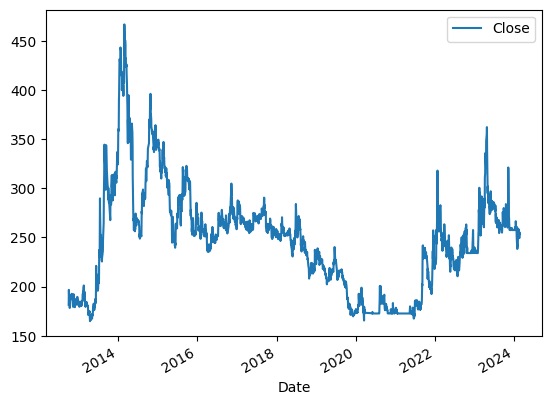

In [ ]:
df.plot()

In [ ]:
# Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

In [ ]:
test_result=adfuller(df['Close'])

Check dataset is stationary or not

If dataset is seasonal then to extra preprocessing

In [ ]:
# It is non stationary
# It is stationary

def adfuller_test(Close):
    result=adfuller(Close)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


In [ ]:
adfuller_test(df['Close'])

ADF Test Statistic : -2.968941799612127
p-value : 0.03789841201562711
#Lags Used : 1
Number of Observations Used : 2648
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Dataset is Stationary

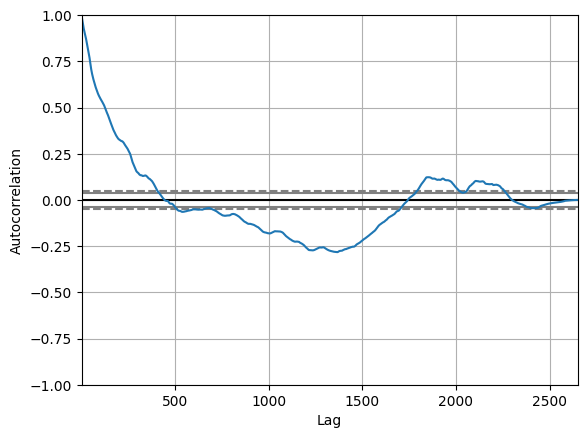

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Close'])
plt.show()

# **ARIMA MODEL**

In [ ]:
# For non-seasonal data
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
model_ARIMA=ARIMA(df['Close'],order=(1,1,1))
model_fit=model_ARIMA.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Split data into training and testing sets
train_data_len = int(len(df) * 0.8)
df_train = df[:train_data_len]
df_test = df[train_data_len:]

This how validation part of dataset predict by ARIMA Model

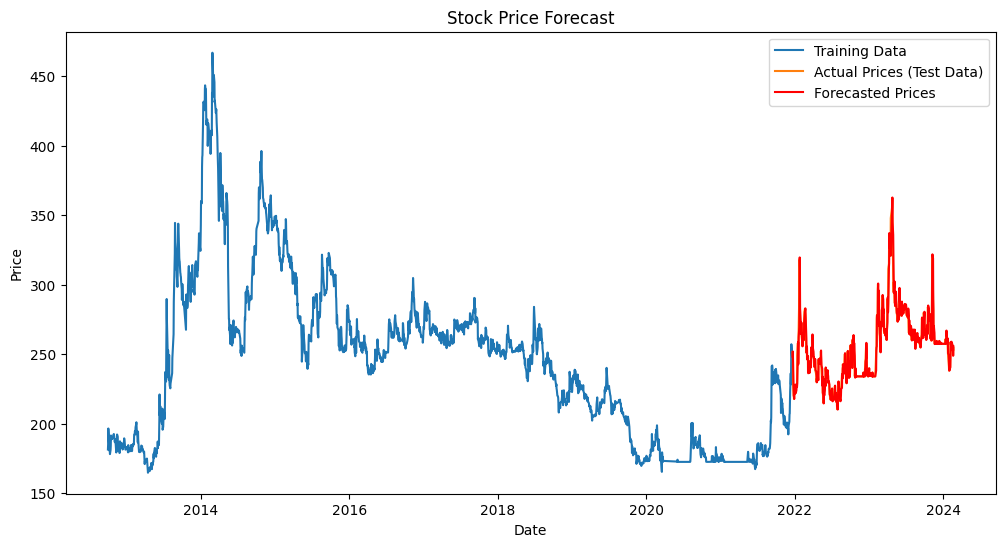

Forecasted Prices for the test set:
Date
2021-12-21    248.274285
2021-12-22    251.956174
2021-12-23    247.268733
2021-12-26    228.304250
2021-12-27    219.915569
                 ...    
2024-02-14    257.489459
2024-02-15    257.181293
2024-02-18    255.182944
2024-02-19    248.928637
2024-02-20    255.656935
Name: predicted_mean, Length: 530, dtype: float64


In [ ]:
# The last part of your notebook corrected

# 1. Get the last actual price from the training set
last_price = df_train['Close'].iloc[-1]

# 2. Predict the future using model_fit and the test set index
forecast_prices = model_fit.predict(start=df_test.index[0], end=df_test.index[-1])

# 3. Plot the results
plt.figure(figsize=(12,6))
plt.plot(df_train['Close'], label='Training Data')
plt.plot(df_test['Close'], label='Actual Prices (Test Data)')
plt.plot(forecast_prices, label='Forecasted Prices', color='red') # Plotting with the index from the prediction
plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# You can also print the forecasted values
print("Forecasted Prices for the test set:")
print(forecast_prices)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Train ARIMA model
model_ARIMA = ARIMA(df_train['Close'], order=(5,1,0))   # (p,d,q) – tune later
model_fit = model_ARIMA.fit()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2120
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -6468.482
Date:                Fri, 03 Oct 2025   AIC                          12948.964
Time:                        22:19:37   BIC                          12982.916
Sample:                             0   HQIC                         12961.394
                               - 2120                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0335      0.012      2.683      0.007       0.009       0.058
ar.L2          0.0066      0.013      0.513      0.608      -0.019       0.032
ar.L3          0.0137      0.013      1.045      0.2

# **Predicted Forecast for next 30 days**

In [ ]:
forecast = model_fit.forecast(steps=30)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
print(forecast)

2120    249.214622
2121    249.670440
2122    249.197266
2123    249.269037
2124    249.329423
2125    249.350090
2126    249.329424
2127    249.332392
2128    249.335781
2129    249.336774
2130    249.335879
2131    249.336011
2132    249.336198
2133    249.336248
2134    249.336210
2135    249.336217
2136    249.336227
2137    249.336230
2138    249.336228
2139    249.336229
2140    249.336229
2141    249.336229
2142    249.336229
2143    249.336229
2144    249.336229
2145    249.336229
2146    249.336229
2147    249.336229
2148    249.336229
2149    249.336229
Name: predicted_mean, dtype: float64


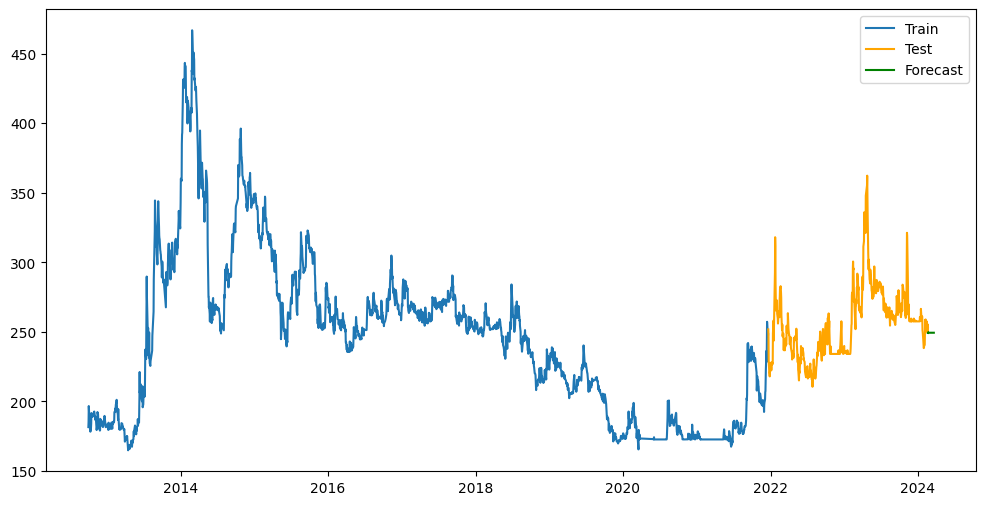

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df_train.index, df_train['Close'], label='Train')
plt.plot(df_test.index, df_test['Close'], label='Test', color='orange')
plt.plot(pd.date_range(df_test.index[-1], periods=30, freq='D'), forecast, label='Forecast', color='green')
plt.legend()
plt.show()

# **RMSE and MAPE table for ARIMA Model**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import math


y_pred = model_fit.forecast(steps=len(df_test))
rmse = np.sqrt(mean_squared_error(df_test['Close'], y_pred))
mape = mean_absolute_percentage_error(df_test['Close'], y_pred)

# Create a performance comparison table
performance_data_arima = {'Metric': ['RMSE', 'MAPE'],
                          'Test': [rmse, mape]}

performance_df_arima = pd.DataFrame(performance_data_arima)

print("ARIMA Model Performance Comparison (Test Set):")
display(performance_df_arima)

ARIMA Model Performance Comparison (Test Set):


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,Metric,Test
0,RMSE,25.010571
1,MAPE,0.074163


RMSE and MAPE table for both LSTM Model and ARIMA model for better comperison

In [ ]:
import pandas as pd



# Create a combined performance comparison table
performance_data_combined = {'Metric': ['RMSE', 'MAPE'],
                             'LSTM Train': [train_rmse, train_mape],
                             'LSTM Test': [test_rmse, test_mape],
                             'ARIMA Test': [rmse, mape]}

performance_df_combined = pd.DataFrame(performance_data_combined)

print("Model Performance Comparison (LSTM vs ARIMA):")
display(performance_df_combined)

Model Performance Comparison (LSTM vs ARIMA):


,Metric,LSTM Train,LSTM Test,ARIMA Test
0,RMSE,5.478190,6.924076,25.010571
1,MAPE,0.014353,0.016766,0.074163


# **LSTM MOdel save as .h5**

In [ ]:
model.save('DataSynthis_Job_task.h5')

## **huggingface upload**

In [ ]:
! pip install huggingface_hub --q